[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'estimator__alpha': 0.1}
Best F1 Score (Macro): 0.9310083350135665
Precision: 0.863332097949745
Recall: 0.875387667887668
F1 Score: 0.8685157371778656


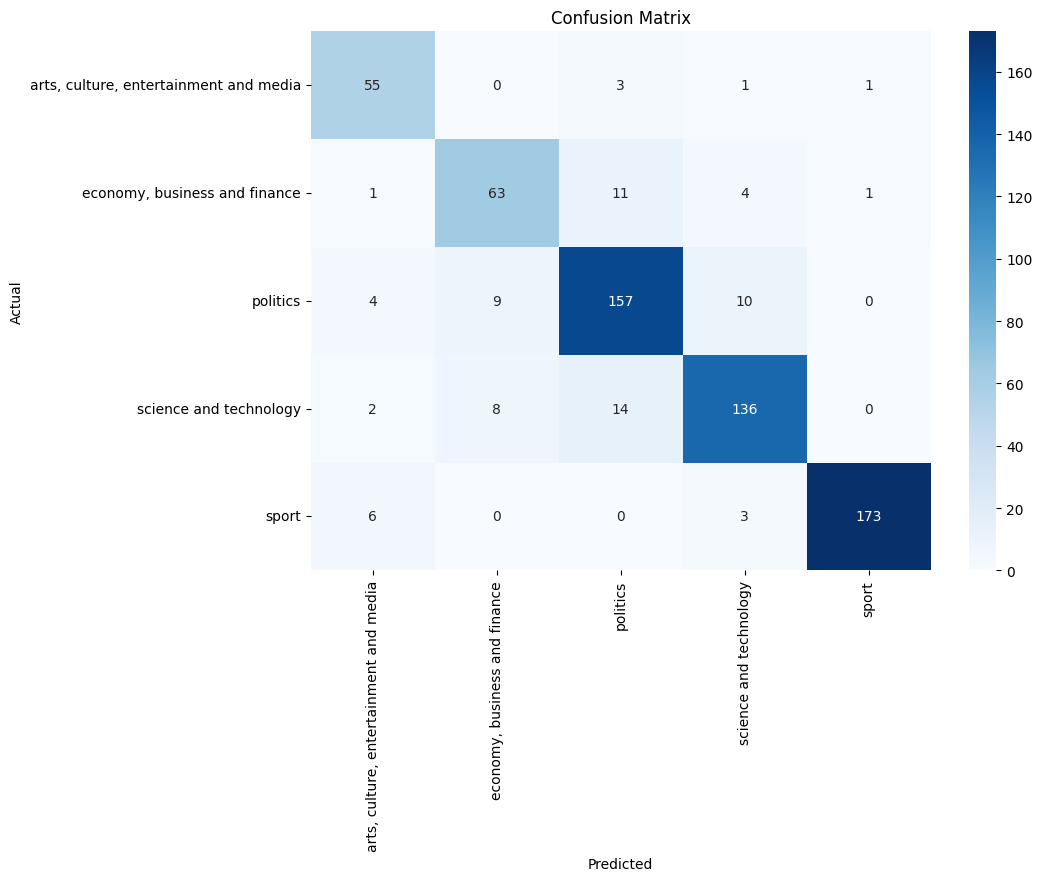


Classification Report:
                                         precision    recall  f1-score   support

arts, culture, entertainment and media       0.81      0.92      0.86        60
         economy, business and finance       0.79      0.79      0.79        80
                              politics       0.85      0.87      0.86       180
                science and technology       0.88      0.85      0.87       160
                                 sport       0.99      0.95      0.97       182

                              accuracy                           0.88       662
                             macro avg       0.86      0.88      0.87       662
                          weighted avg       0.88      0.88      0.88       662



In [3]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# ดาวน์โหลด stopwords และ lemmatizer ถ้ายังไม่ได้ทำ
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ขยาย stopwords เพิ่มเติม
default_stopwords = stopwords.words('english')
additional_stopwords = [
    'said', 'would', 'even', 'according', 'could', 'year',
    'years', 'also', 'new', 'people', 'old', 'one', 'two', 'time',
    'first', 'last', 'say', 'make', 'best', 'get', 'three', 'make',
    'year old', 'told', 'made', 'like', 'take', 'many', 'set', 'number',
    'month', 'week', 'well', 'back'
]
default_stopwords += additional_stopwords

# กำหนด regex สำหรับทำความสะอาดข้อความ
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

def clean_text(text):
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w) >= 3]

    def preprocessing_text(text):
        text = text.lower()
        text = text.replace('\n',' ').replace('\xa0',' ').replace('-',' ') \
                   .replace('ó','o').replace('ğ','g').replace('á','a').replace("'"," ")
        text = re.sub(r'\d+','', text)
        text = re.sub(r'http\S+', '', text)
        text = BAD_SYMBOLS_RE.sub(' ', text)
        text = REPLACE_IP_ADDRESS.sub('', text)
        text = REPLACE_BY_SPACE_RE.sub(' ', text)
        text = ' '.join(word for word in text.split() if len(word) > 3)
        return text

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters + '0123456789')))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ')  # ลบช่องว่างข้างหน้าและข้างหลัง
    text = preprocessing_text(text)
    text = remove_special_characters(text)  # ลบเครื่องหมายวรรคตอนและสัญลักษณ์
    text = lemm_text(text)  # Lemmatization
    text = remove_stopwords(text)  # ลบ stopwords

    return text

# โหลดข้อมูล
df = pd.read_csv('MN-DS-news-classification.csv')

# เลือกหมวดหมู่ที่สนใจ
selected_categories = [
    'arts, culture, entertainment and media',
    'economy, business and finance',
    'politics',
    'science and technology',
    'sport'
]
df = df[df['category_level_1'].isin(selected_categories)]

# รวมคอลัมน์ title และ content เข้าด้วยกัน
df['text'] = df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)), axis=1)

# ทำความสะอาดข้อความ
df['text'] = df['text'].apply(clean_text)

# ฟังก์ชันสำหรับแปลงข้อความเป็น TF-IDF vectors
def get_tfidf(X):
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        analyzer='word',
        ngram_range=(1,2),
        norm='l2',
        max_features=20000,  # ปรับลดจาก 50000 เพื่อความเร็ว
        max_df=0.9,          # ลบคำที่เกิดขึ้นมากกว่า 90%
        min_df=5             # ลบคำที่เกิดขึ้นน้อยกว่า 5 ครั้ง
    )
    vectors = vectorizer.fit_transform(X)
    return vectors, vectorizer

# แปลงข้อความเป็น TF-IDF vectors
X_tfidf, vectorizer = get_tfidf(df['text'])

# เข้ารหัส labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category_level_1'])

# แบ่งข้อมูลเป็น training และ testing sets โดยใช้ stratify เพื่อรักษาสัดส่วนของแต่ละคลาส
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# จัดการกับความไม่สมดุลของข้อมูลด้วย SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# สร้างโมเดล OneVsRestClassifier กับ MultinomialNB
model = OneVsRestClassifier(MultinomialNB())

# ตั้งค่าพารามิเตอร์สำหรับ Grid Search
param_grid = {
    'estimator__alpha': [0.1, 0.5, 1.0],  # ค่า smoothing parameter
}

# สร้าง GridSearchCV เพื่อค้นหาพารามิเตอร์ที่ดีที่สุด
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# ฝึกโมเดลด้วย Grid Search
grid_search.fit(X_train_res, y_train_res)

# แสดงพารามิเตอร์ที่ดีที่สุด
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (Macro):", grid_search.best_score_)

# ใช้โมเดลที่ดีที่สุด
best_model = grid_search.best_estimator_

# ทำนายบน test set
y_pred = best_model.predict(X_test)

# ประเมินโมเดล
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# สร้าง Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = best_model.classes_
label_names = label_encoder.inverse_transform(labels)  # แปลงรหัสกลับเป็นชื่อคลาส

# แสดง Confusion Matrix ด้วย Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# แสดง Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


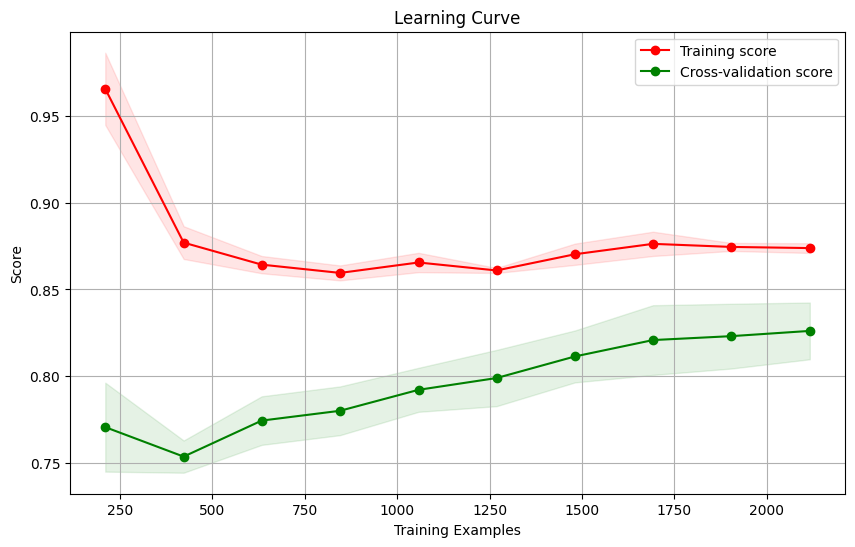

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐาน
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # วาดกราฟ
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    # เติมส่วนเบี่ยงเบนมาตรฐาน
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# เรียกใช้ฟังก์ชัน plot_learning_curve ด้วยโมเดลที่คุณฝึก
plot_learning_curve(model, X_train, y_train)


Precision: 0.8901559337030056
Recall: 0.8156288156288156
F1 Score: 0.8415279979652539


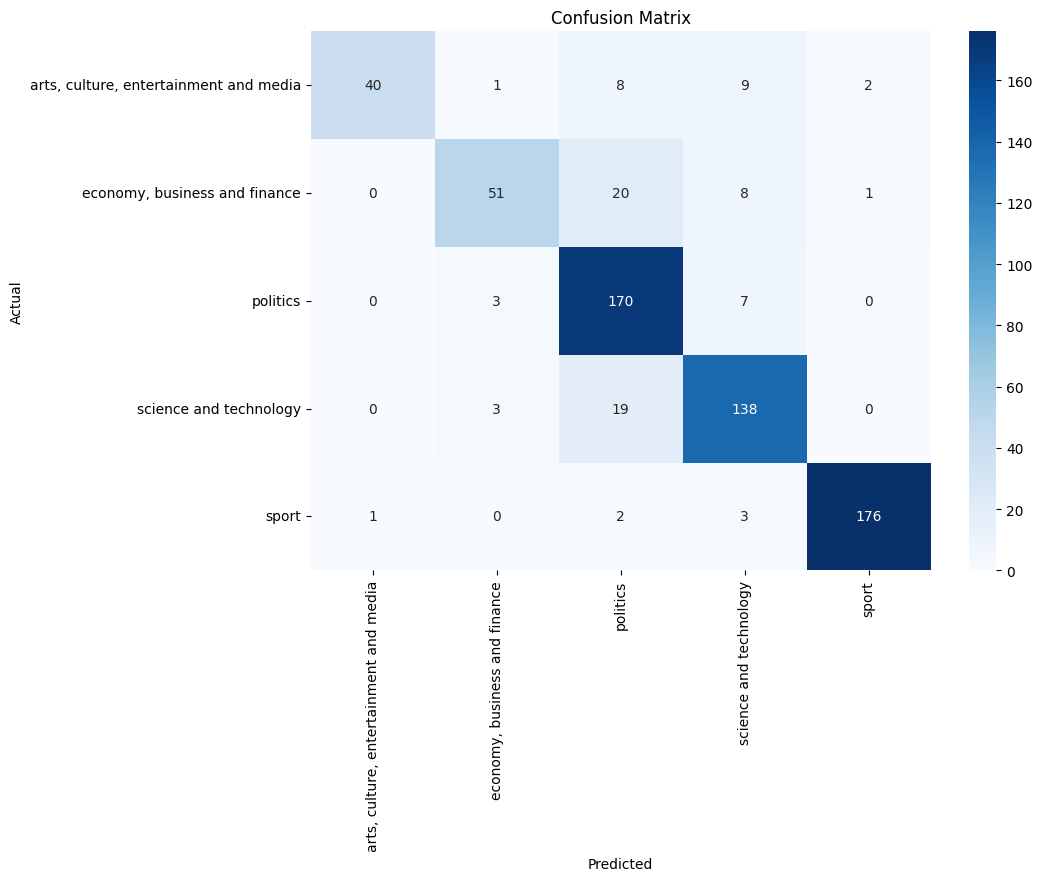


Classification Report:
                                         precision    recall  f1-score   support

arts, culture, entertainment and media       0.98      0.67      0.79        60
         economy, business and finance       0.88      0.64      0.74        80
                              politics       0.78      0.94      0.85       180
                science and technology       0.84      0.86      0.85       160
                                 sport       0.98      0.97      0.98       182

                              accuracy                           0.87       662
                             macro avg       0.89      0.82      0.84       662
                          weighted avg       0.88      0.87      0.87       662



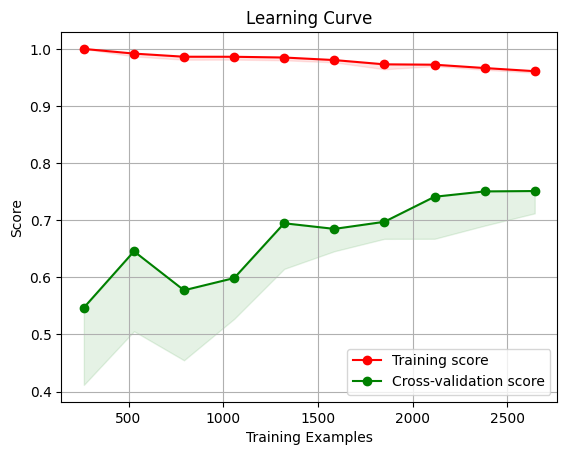

In [5]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

# Expand stopwords
default_stopwords = stopwords.words('english')
additional_stopwords = ['said', 'would', 'even', 'according', 'could', 'year',
                        'years', 'also', 'new', 'people', 'old', 'one', 'two', 'time',
                        'first', 'last', 'say', 'make', 'best', 'get', 'three', 'make',
                        'year old', 'told', 'made', 'like', 'take', 'many', 'set', 'number',
                        'month', 'week', 'well', 'back']
default_stopwords += additional_stopwords

# Regex for text cleaning
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

def clean_text(text):
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w) >= 3]

    def preprocessing_text(text):
        text = text.lower()
        text = text.replace('\n', ' ').replace('\xa0', ' ').replace('-', ' ') \
                   .replace('ó', 'o').replace('ğ', 'g').replace('á', 'a').replace("'", " ")
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = BAD_SYMBOLS_RE.sub(' ', text)
        text = REPLACE_IP_ADDRESS.sub('', text)
        text = REPLACE_BY_SPACE_RE.sub(' ', text)
        text = ' '.join(word for word in text.split() if len(word) > 3)
        return text

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ')
    text = preprocessing_text(text)
    text = lemm_text(text)
    text = remove_stopwords(text)

    return text

# Load data
df = pd.read_csv('MN-DS-news-classification.csv')

# Select relevant categories
selected_categories = [
    'arts, culture, entertainment and media',
    'economy, business and finance',
    'politics',
    'science and technology',
    'sport'
]
df = df[df['category_level_1'].isin(selected_categories)]

# Combine title and content
df['text'] = df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)), axis=1)

# Clean text
df['text'] = df['text'].apply(clean_text)

# Function to convert text to TF-IDF vectors
def get_tfidf(X):
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        analyzer='word',
        ngram_range=(1, 2),
        norm='l2',
        max_features=50000
    )
    vectors = vectorizer.fit_transform(X)
    return vectors

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category_level_1'])

# Convert text to TF-IDF vectors
X_tfidf = get_tfidf(df['text'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Create OneVsRestClassifier with MultinomialNB
model = OneVsRestClassifier(MultinomialNB(alpha=0.1))

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = model.classes_
label_names = label_encoder.inverse_transform(labels)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_tfidf,
    y_encoded,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_macro'
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.plot(train_sizes, train_scores_mean, 'o-', color='red', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean, train_scores_mean - train_scores.std(axis=1),
                 alpha=0.1, color='red')
plt.fill_between(train_sizes, test_scores_mean, test_scores_mean - test_scores.std(axis=1),
                 alpha=0.1, color='green')
plt.legend(loc='best')
plt.grid()
plt.show()


Precision: 0.8901559337030056
Recall: 0.8156288156288156
F1 Score: 0.8415279979652539


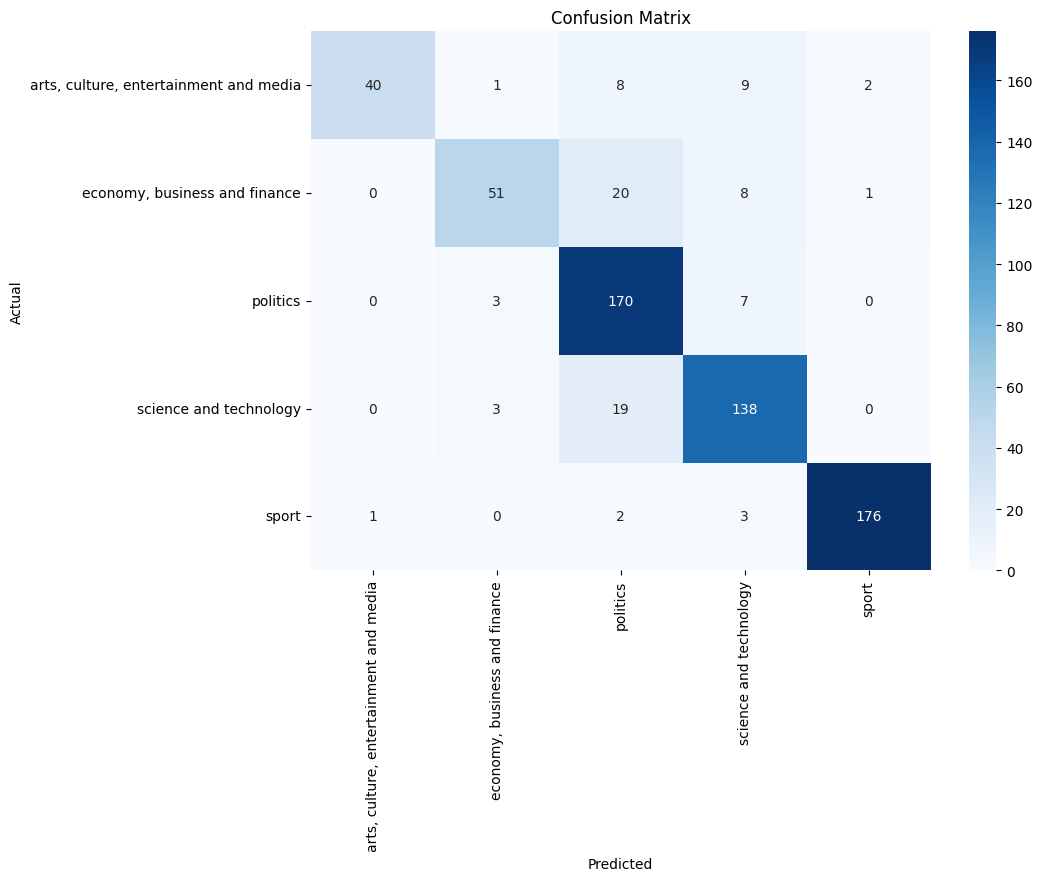


Classification Report:
                                         precision    recall  f1-score   support

arts, culture, entertainment and media       0.98      0.67      0.79        60
         economy, business and finance       0.88      0.64      0.74        80
                              politics       0.78      0.94      0.85       180
                science and technology       0.84      0.86      0.85       160
                                 sport       0.98      0.97      0.98       182

                              accuracy                           0.87       662
                             macro avg       0.89      0.82      0.84       662
                          weighted avg       0.88      0.87      0.87       662



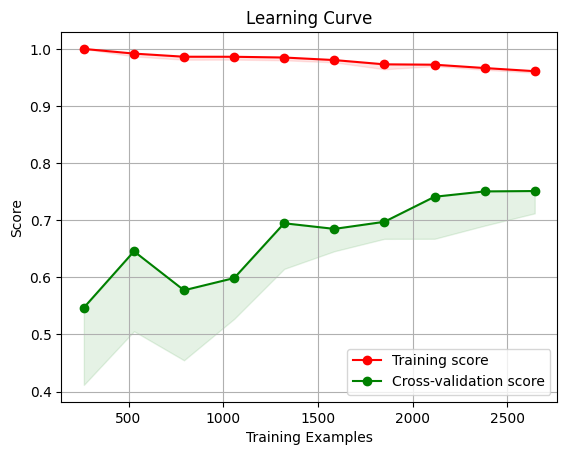

In [3]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import numpy as np
# Expand stopwords
default_stopwords = stopwords.words('english')
additional_stopwords = ['said', 'would', 'even', 'according', 'could', 'year',
                        'years', 'also', 'new', 'people', 'old', 'one', 'two', 'time',
                        'first', 'last', 'say', 'make', 'best', 'get', 'three', 'make',
                        'year old', 'told', 'made', 'like', 'take', 'many', 'set', 'number',
                        'month', 'week', 'well', 'back']
default_stopwords += additional_stopwords

# Regex for text cleaning
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

def clean_text(text):
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w) >= 3]

    def preprocessing_text(text):
        text = text.lower()
        text = text.replace('\n', ' ').replace('\xa0', ' ').replace('-', ' ') \
                   .replace('ó', 'o').replace('ğ', 'g').replace('á', 'a').replace("'", " ")
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = BAD_SYMBOLS_RE.sub(' ', text)
        text = REPLACE_IP_ADDRESS.sub('', text)
        text = REPLACE_BY_SPACE_RE.sub(' ', text)
        text = ' '.join(word for word in text.split() if len(word) > 3)
        return text

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ')
    text = preprocessing_text(text)
    text = lemm_text(text)
    text = remove_stopwords(text)

    return text

# Load data
df = pd.read_csv('MN-DS-news-classification.csv')

# Select relevant categories
selected_categories = [
    'arts, culture, entertainment and media',
    'economy, business and finance',
    'politics',
    'science and technology',
    'sport'
]
df = df[df['category_level_1'].isin(selected_categories)]

# Combine title and content
df['text'] = df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)), axis=1)

# Clean text
df['text'] = df['text'].apply(clean_text)

# Function to convert text to TF-IDF vectors
def get_tfidf(X):
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        analyzer='word',
        ngram_range=(1, 2),
        norm='l2',
        max_features=50000
    )
    vectors = vectorizer.fit_transform(X)
    return vectors

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category_level_1'])

# Convert text to TF-IDF vectors
X_tfidf = get_tfidf(df['text'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Create OneVsRestClassifier with MultinomialNB
model = OneVsRestClassifier(MultinomialNB(alpha=0.1))

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = model.classes_
label_names = label_encoder.inverse_transform(labels)

# Plot Confusion Matrix with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_tfidf,
    y_encoded,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_macro'
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.plot(train_sizes, train_scores_mean, 'o-', color='red', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean, train_scores_mean - train_scores.std(axis=1),
                 alpha=0.1, color='red')
plt.fill_between(train_sizes, test_scores_mean, test_scores_mean - test_scores.std(axis=1),
                 alpha=0.1, color='green')
plt.legend(loc='best')
plt.grid()
plt.show()


In [4]:
import numpy as np

# ทำนายผลในชุดข้อมูลทดสอบ
y_pred = model.predict(X_test)

# ตรวจสอบจำนวนคลาสที่ถูกทำนาย
predicted_classes = np.unique(y_pred)

# แสดงผลจำนวนคลาสที่ถูกทำนาย
print("Number of classes predicted:", len(predicted_classes))
print("Predicted classes:", predicted_classes)


Number of classes predicted: 5
Predicted classes: [0 1 2 3 4]
